## Cohort Analysis


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import plotly.express as px

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('float_format', '{:,.2f}'.format)

### Load dataset

In [3]:
online_data= pd.read_excel('dataset/Online Retail.xlsx')
online_data.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
461210,575931,23374,RED SPOT PAPER GIFT BAG,10,2011-11-13 10:35:00,0.82,"16,560.00",United Kingdom
36220,539444,22752,SET 7 BABUSHKA NESTING BOXES,24,2010-12-17 15:52:00,7.65,"14,146.00",United Kingdom
95607,544462,21892,TRADITIONAL WOODEN CATCH CUP GAME,4,2011-02-20 14:21:00,1.25,"17,050.00",United Kingdom
452311,575331,23389,SPACEBOY MINI BACKPACK,8,2011-11-09 13:52:00,4.15,"13,209.00",United Kingdom
46954,540372,22637,PIGGY BANK RETROSPOT,12,2011-01-06 16:41:00,2.55,"13,081.00",United Kingdom


### Data cleaning
This cells explains the quality of the dataset showing missing columns, number of rows and column and data types.

In [4]:
online_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


#### Handle duplicate values
In the above output, there are 8 columns, with some columns having missing values.

In [5]:
print(f'There are {online_data.duplicated().sum()} duplicate in the dataset.')

There are 5268 duplicate in the dataset.


In [6]:
# drop all duplicate
online_data.drop_duplicates(keep='first', inplace=True)
print(f'After dropping duplicate rows, there are {online_data.duplicated().sum()} duplicate in the dataset.')

After dropping duplicate rows, there are 0 duplicate in the dataset.


#### Handle missing values

There are 2 columns with large number of missing values as seen above, how do we handle it? The missing rows in customerID column will be dropped because it can not be researched or statistically calculated. 

It is as well observed that dropping all missing values in *customerID* eliminate missing values in *Description* column as well.

In [7]:
# check missing values
online_data.isna().sum().sort_values(ascending=False)

CustomerID     135037
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

In [8]:
# drop missing values
online_data.dropna(subset=['CustomerID'], inplace=True)

# check missing values after dropping
online_data.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Remove InvoiceNo that start with C which implies *Cancelled* transaction.

In [9]:
online_data=online_data[online_data['InvoiceNo'].str.startswith('C')!= True]

In [10]:
# calculate total amount of product purchased by each customers
online_data['Amount'] = online_data['Quantity'] * online_data['UnitPrice']

In [11]:
online_data.describe()

,Quantity,UnitPrice,CustomerID,Amount
count,"392,732.00","392,732.00","392,732.00","392,732.00"
mean,13.15,3.13,"15,287.73",22.63
std,181.59,22.24,"1,713.57",311.08
min,1.00,0.00,"12,346.00",0.00
25%,2.00,1.25,"13,955.00",4.95
50%,6.00,1.95,"15,150.00",12.39
75%,12.00,3.75,"16,791.00",19.80
max,"80,995.00","8,142.75","18,287.00","168,469.60"


In [12]:
# export the cleaned dataset to be use in rfm
online_data.to_csv('dataset/cleaned_online_data.csv', index=False)  

### Cohort calculations

Cohort requirement:

Active month: This will be generated from the invoiceDate column. To get the month each users made a transaction.

Cohort month: This will be generated from the invoiceDate column. To get the first transaction made by each users.

Month since first: This will calculate the number of month between first transaction and other transactions made by each customers. 



In [13]:
# create active month using string from time(strftime) which automatically set the day to 01
online_data['InvoiceMonth'] = online_data['InvoiceDate'].dt.strftime('%Y-%m')

# convert new variable to datetime format
online_data['InvoiceMonth'] = pd.to_datetime(online_data['InvoiceMonth'])

# cohort month
online_data['CohortMonth'] = online_data.groupby('CustomerID')['InvoiceMonth'].transform('min')

In [14]:
# month since first
def month_since_first(other, first):
    """ calculate month since first transaction made by each customers.
    Args:
    other (str): invoice date, each month a customer made a transaction.
    first (str): first transaction date.
    
    Returns:
    A new columns of each customers month since first values on the dataframe will be generated
    """
    
    return (other.dt.year - first.dt.year) * 12 + (other.dt.month - first.dt.month)
online_data['MonthSinceFirst'] = month_since_first(online_data['InvoiceMonth'],online_data['CohortMonth'])


online_data.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,InvoiceMonth,CohortMonth,MonthSinceFirst
227644,556890,22197,SMALL POPCORN HOLDER,24,2011-06-15 12:48:00,0.85,"17,581.00",United Kingdom,20.40,2011-06-01,2010-12-01,6
362834,568526,22336,DOVE DECORATION PAINTED ZINC,96,2011-09-27 13:04:00,0.19,"17,656.00",United Kingdom,18.24,2011-09-01,2011-08-01,1
305528,563697,23209,LUNCH BAG VINTAGE DOILY,2,2011-08-18 13:44:00,1.65,"16,813.00",United Kingdom,3.30,2011-08-01,2011-05-01,3
410439,572103,21369,MIRRORED WALL ART SPLODGES,1,2011-10-20 15:57:00,1.25,"17,571.00",United Kingdom,1.25,2011-10-01,2011-02-01,8
169503,551181,22423,REGENCY CAKESTAND 3 TIER,24,2011-04-27 08:17:00,10.95,"13,089.00",United Kingdom,262.80,2011-04-01,2010-12-01,4


#### User transaction cohort
The calculated metrics on this table, count active users in each month, active users is defined as users who carry out transaction.

In [15]:
customer_cohort = pd.pivot_table(online_data, 
                              columns='MonthSinceFirst', 
                              index='CohortMonth',
                              values='CustomerID', aggfunc='nunique')
customer_cohort

MonthSinceFirst,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.00,324.00,286.00,340.00,321.00,352.00,321.00,309.00,313.00,350.00,331.00,445.00,235.00
2011-01-01,417.00,92.00,111.00,96.00,134.00,120.00,103.00,101.00,125.00,136.00,152.00,49.00,NaN
2011-02-01,380.00,71.00,71.00,108.00,103.00,94.00,96.00,106.00,94.00,116.00,26.00,NaN,NaN
2011-03-01,452.00,68.00,114.00,90.00,101.00,76.00,121.00,104.00,126.00,39.00,NaN,NaN,NaN
2011-04-01,300.00,64.00,61.00,63.00,59.00,68.00,65.00,78.00,22.00,NaN,NaN,NaN,NaN
2011-05-01,284.00,54.00,49.00,49.00,59.00,66.00,75.00,27.00,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.00,42.00,38.00,64.00,56.00,81.00,23.00,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.00,34.00,39.00,42.00,51.00,21.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.00,35.00,42.00,41.00,21.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Retention Rate

In [16]:
# get the first column in cohort count table
cohort_size = customer_cohort.iloc[:,0]

retention = customer_cohort.divide(cohort_size, axis =0)  # divide values in cohort_count table by cohort_size
retention.round(3) * 100   # show retention as %

MonthSinceFirst,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.00,36.60,32.30,38.40,36.30,39.80,36.30,34.90,35.40,39.50,37.40,50.30,26.60
2011-01-01,100.00,22.10,26.60,23.00,32.10,28.80,24.70,24.20,30.00,32.60,36.50,11.80,NaN
2011-02-01,100.00,18.70,18.70,28.40,27.10,24.70,25.30,27.90,24.70,30.50,6.80,NaN,NaN
2011-03-01,100.00,15.00,25.20,19.90,22.30,16.80,26.80,23.00,27.90,8.60,NaN,NaN,NaN
2011-04-01,100.00,21.30,20.30,21.00,19.70,22.70,21.70,26.00,7.30,NaN,NaN,NaN,NaN
2011-05-01,100.00,19.00,17.30,17.30,20.80,23.20,26.40,9.50,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.00,17.40,15.70,26.40,23.10,33.50,9.50,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.00,18.10,20.70,22.30,27.10,11.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.00,20.70,24.90,24.30,12.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


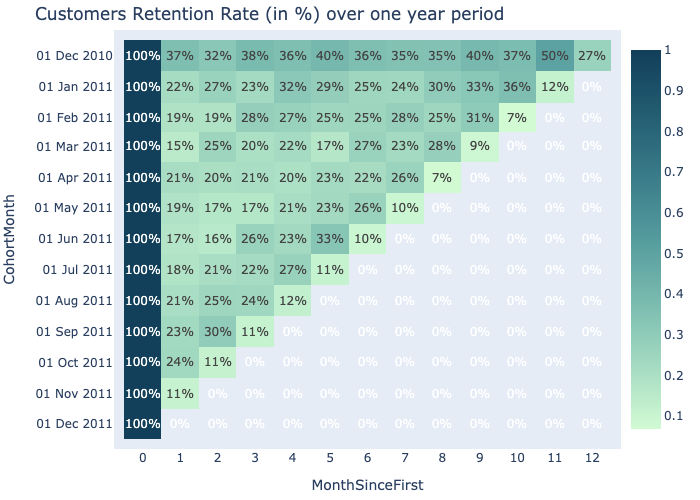

In [17]:
# heatmap
fig = px.imshow(retention, 
                text_auto='.0%', 
                color_continuous_scale='darkmint', 
                aspect='auto')
fig.update_layout(title_text = 'Customers Retention Rate (in %) over one year period',
                  margin = dict(l=10, r=10, t=40, b=10, pad=10),
                  xaxis = dict(zeroline=False, showgrid=False),
                  yaxis = dict(zeroline=True, showgrid=False, scaleanchor='x'),
                  xaxis_nticks=26)
fig.update_layout(yaxis = dict(tickformat = '%d %b %Y', 
                             tickvals = online_data['CohortMonth']))

fig.update(data = [{'hovertemplate': 'Month after first transaction: %{x}<br>Cohort: %{y}<br>Customer Cohort %: %{z}<extra></extra>'}])
fig.show(renderer="png")  # show this as a png due to github not able to render embedded html in notebooks

## Observations
*  The above heatmap displays the over-time customers retained, i.e customers that started purchasing in each cohort and the number of them that kept on purchasing over-time.

*  It is observed that in the 11th month of Dec, 2010 cohort, the number of customers that made purchases increase by 50% which was the only month with the highest number of purchasing customers. We should investigate on what we did that escalated that number inorder to do more of it to yield active customers.

*  In the 12th month, which is the last month of purchase on the map, the number of customers dropped in each cohort rigoriously compared to their preceeding month. Could that be as a result of festival season? 

#### Average Spending Over-time

In [18]:
amount_cohort = pd.pivot_table(online_data, 
                              columns='MonthSinceFirst', 
                              index='CohortMonth',
                              values='Amount', aggfunc='mean')
amount_cohort

MonthSinceFirst,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,22.22,27.26,26.86,27.19,21.19,28.14,28.34,27.43,29.24,33.46,33.99,23.63,25.84
2011-01-01,26.88,25.10,20.97,31.23,22.47,26.28,25.24,25.49,19.07,22.33,19.72,19.78,NaN
2011-02-01,17.87,20.85,21.45,19.36,17.69,16.97,22.17,22.90,18.79,22.18,23.50,NaN,NaN
2011-03-01,17.59,21.14,22.69,18.02,21.11,19.00,22.03,19.99,16.80,13.20,NaN,NaN,NaN
2011-04-01,16.95,21.03,19.49,18.74,19.55,15.00,15.25,15.97,12.34,NaN,NaN,NaN,NaN
2011-05-01,20.48,17.34,22.22,20.90,18.59,14.11,17.02,234.53,NaN,NaN,NaN,NaN,NaN
2011-06-01,23.98,16.29,19.95,20.45,15.35,16.71,13.22,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,14.96,23.53,11.79,13.02,10.88,11.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,16.52,13.16,12.53,15.88,17.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


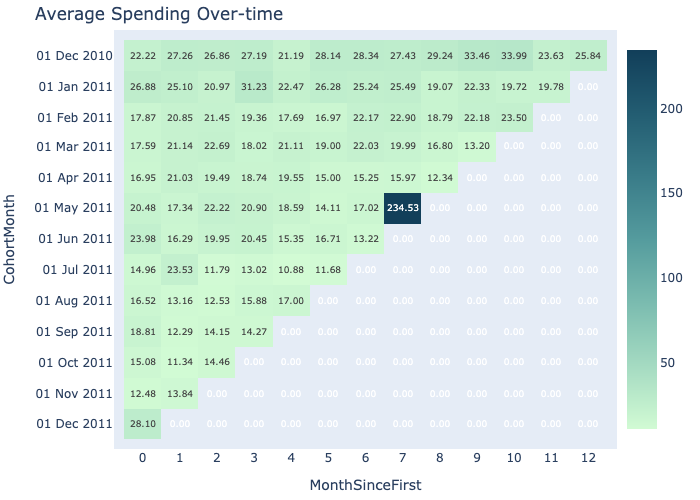

In [20]:
fig = px.imshow(amount_cohort, 
                text_auto='.2f', 
                color_continuous_scale='darkmint', 
                aspect='auto')
fig.update_layout(title_text = 'Average Spending Over-time ',
                  margin = dict(l=10, r=10, t=40, b=10, pad=10),
                  xaxis = dict(zeroline=False, showgrid=False),
                  yaxis = dict(zeroline=True, showgrid=False, scaleanchor='x'),
                  xaxis_nticks=26)
fig.update_layout(yaxis = dict(tickformat = '%d %b %Y', 
                             tickvals = online_data['CohortMonth']))

fig.update(data = [{'hovertemplate': 'Month after first transaction: %{x}<br>Cohort: %{y}<br>Customer Cohort %: %{z}<extra></extra>'}])
fig.show(renderer="png")  # show this as a png due to github not able to render embedded html in notebooks

## Observations
*  The map above shows average amount of purchases made by each cohort over-time.
* In the 7th month of May 2011, the amount of product purchased grew more time the starting and preceeding amount in that cohort and generally in the whole one year. This means customers in that cohort purchased more product in that week. Though the number of customers reduced to 10% from their previously had 26% in the 6th month.
There is need to investigate on the product that was widely purchased, customers that made the purchase in that month and what could be the cause of the escalation in value compared to other month of the year. 